# Processing of EUR pricing

Set the working directory as usual:

In [1]:
import os

os.chdir("/media/dftortosa/Windows/Users/dftor/Documents/diego_docs/industry/data_incubator/capstone_project/")
os.getcwd()

'/media/dftortosa/Windows/Users/dftor/Documents/diego_docs/industry/data_incubator/capstone_project'

## Loading EUR pricing 

EUR/USD exchange was downloaded from the [ECB webpage](https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/eurofxref-graph-usd.en.html):

In [2]:
import xmltodict

xml_data = open('data/eur_pricing/euro_usd_until_august_2022.xml', 'r').read()
xmlDict = xmltodict.parse(xml_data)
    #https://stackabuse.com/reading-and-writing-xml-files-in-python-with-pandas/

Get dicts containing the value for Euro across time:

In [3]:
dicts_pricing = xmlDict["CompactData"]["DataSet"]["Series"]["Obs"]
dicts_pricing[0:3]

[OrderedDict([('@TIME_PERIOD', '1999-01-04'),
              ('@OBS_VALUE', '1.1789'),
              ('@OBS_STATUS', 'A'),
              ('@OBS_CONF', 'F')]),
 OrderedDict([('@TIME_PERIOD', '1999-01-05'),
              ('@OBS_VALUE', '1.1790'),
              ('@OBS_STATUS', 'A'),
              ('@OBS_CONF', 'F')]),
 OrderedDict([('@TIME_PERIOD', '1999-01-06'),
              ('@OBS_VALUE', '1.1743'),
              ('@OBS_STATUS', 'A'),
              ('@OBS_CONF', 'F')])]

This is a list of dictionaries:

In [4]:
print(type(dicts_pricing))
print(type(dicts_pricing[0]))

<class 'list'>
<class 'collections.OrderedDict'>


So I can extract the date and the observed value (pricing) in each dict:

In [5]:
print((dicts_pricing[0]["@TIME_PERIOD"], (dicts_pricing[0]["@OBS_VALUE"])))

('1999-01-04', '1.1789')


OBS_STATUS and OBS_CONF are exactly the same across the whole dataset

In [6]:
import numpy as np
print(np.unique([dictionary["@OBS_STATUS"] for dictionary in dicts_pricing]))
print(np.unique([dictionary["@OBS_CONF"] for dictionary in dicts_pricing]))

['A']
['F']


## Process EUR data 

Get the value and date saving as pandas DF:

In [7]:
import pandas as pd

eur_pricing_pd = pd.DataFrame([(dictionary["@TIME_PERIOD"], dictionary["@OBS_VALUE"]) for dictionary in dicts_pricing])
eur_pricing_pd

,0,1
0,1999-01-04,1.1789
1,1999-01-05,1.1790
2,1999-01-06,1.1743
3,1999-01-07,1.1632
4,1999-01-08,1.1659
...,...,...
6053,2022-08-22,1.0001
6054,2022-08-23,0.9927
6055,2022-08-24,0.9934
6056,2022-08-25,0.9970


Name the columns:

In [8]:
eur_pricing_pd = eur_pricing_pd.set_axis(["date", "eur_usd_rate"], axis=1, inplace=False)
eur_pricing_pd

,date,eur_usd_rate
0,1999-01-04,1.1789
1,1999-01-05,1.1790
2,1999-01-06,1.1743
3,1999-01-07,1.1632
4,1999-01-08,1.1659
...,...,...
6053,2022-08-22,1.0001
6054,2022-08-23,0.9927
6055,2022-08-24,0.9934
6056,2022-08-25,0.9970


Change the format of the columns:

In [9]:
#convert pricing to numeric
eur_pricing_pd["eur_usd_rate"] = pd.to_numeric(eur_pricing_pd["eur_usd_rate"])
    #https://stackoverflow.com/questions/15891038/change-column-type-in-pandas
    
#convert date to datetime
eur_pricing_pd["date"] = pd.to_datetime(eur_pricing_pd["date"])

#look
eur_pricing_pd

,date,eur_usd_rate
0,1999-01-04,1.1789
1,1999-01-05,1.1790
2,1999-01-06,1.1743
3,1999-01-07,1.1632
4,1999-01-08,1.1659
...,...,...
6053,2022-08-22,1.0001
6054,2022-08-23,0.9927
6055,2022-08-24,0.9934
6056,2022-08-25,0.9970


Plot the EUR/USD exchange rate since 1999:

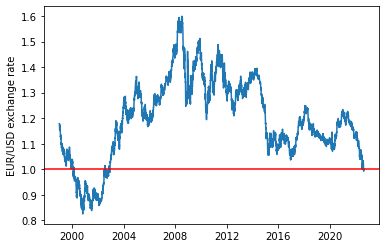

In [10]:
import matplotlib.pyplot as plt

plt.plot(eur_pricing_pd["date"], eur_pricing_pd["eur_usd_rate"])
plt.axhline(y=1, color='r', linestyle='-') #red line for EUR/USD parity
plt.ylabel('EUR/USD exchange rate')
plt.show()

This is similar to that show in the web page of the ECB:

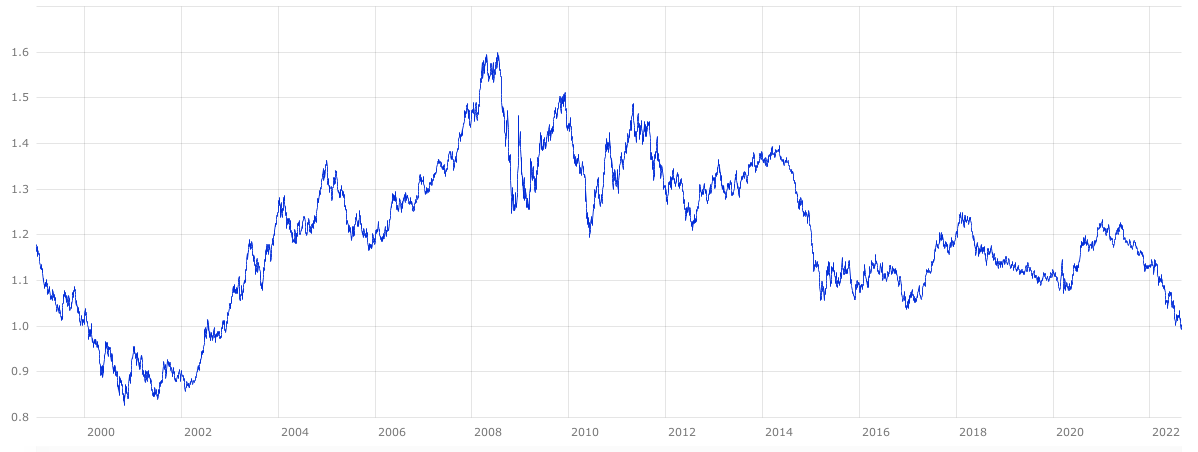

Probably the most interesting thing is the peak in 2008 and then the continuous decrease. Some economists say that until 2008, the euro was a strong candidate disputing the position of global currency of the dollar, but in the debt crisis of 2008-2012, the ECB made clear that it would do what ever it takes to avoid the default of European countries, and this means purchasing low-quality assets like bonds of countries with a high sovereing debt. This decreased the quality of the assests backing the Euro and hence potentially reducing the future ability of the ECB to control the value of its currency. Because of this, economy agents reduced their expectations about the Euro since 2008.

## Create predictors using previous EUR pricing

I will use the previous EUR/USD exchange ratio to create variables with the potential to predict the current EUR pricing.

First, I am going to create a new column with the eur pricing of the previous day. We have continous data, one day per row without gaps, so we can easily calculate the eur pricing of the exact previous day:

In [11]:
eur_pricing_pd["previous_eur_pricing"] = eur_pricing_pd["eur_usd_rate"].shift(1)
    #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html
eur_pricing_pd

,date,eur_usd_rate,previous_eur_pricing
0,1999-01-04,1.1789,NaN
1,1999-01-05,1.1790,1.1789
2,1999-01-06,1.1743,1.1790
3,1999-01-07,1.1632,1.1743
4,1999-01-08,1.1659,1.1632
...,...,...,...
6053,2022-08-22,1.0001,1.0054
6054,2022-08-23,0.9927,1.0001
6055,2022-08-24,0.9934,0.9927
6056,2022-08-25,0.9970,0.9934


Now, I am going to check that the value in "previous_eur_pricing" is equal to "eur_usd_rate" of the previous row:

In [12]:
check = [] #empty list to save results

#iterate across the pandas df
for index, row in eur_pricing_pd.T.iteritems():
    
    #avoid the first row that obviously has no previous eur value
    if index > 0:
        check.append(row["previous_eur_pricing"] == eur_pricing_pd["eur_usd_rate"].iloc[index-1])

#see that all True
all(check)

True

I am going to include as predictors the rolling mean of previous days.

In [13]:
eur_pricing_pd["5_days_rolling_mean_pricing"] = eur_pricing_pd["previous_eur_pricing"].rolling(5).mean()
eur_pricing_pd["10_days_rolling_mean_pricing"] = eur_pricing_pd["previous_eur_pricing"].rolling(10).mean()
eur_pricing_pd["60_days_rolling_mean_pricing"] = eur_pricing_pd["previous_eur_pricing"].rolling(60).mean()
eur_pricing_pd["120_days_rolling_mean_pricing"] = eur_pricing_pd["previous_eur_pricing"].rolling(120).mean()
eur_pricing_pd

,date,eur_usd_rate,previous_eur_pricing,5_days_rolling_mean_pricing,10_days_rolling_mean_pricing,60_days_rolling_mean_pricing,120_days_rolling_mean_pricing
0,1999-01-04,1.1789,NaN,NaN,NaN,NaN,NaN
1,1999-01-05,1.1790,1.1789,NaN,NaN,NaN,NaN
2,1999-01-06,1.1743,1.1790,NaN,NaN,NaN,NaN
3,1999-01-07,1.1632,1.1743,NaN,NaN,NaN,NaN
4,1999-01-08,1.1659,1.1632,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
6053,2022-08-22,1.0001,1.0054,1.01444,1.02030,1.034628,1.057292
6054,2022-08-23,0.9927,1.0001,1.01056,1.01832,1.033357,1.056397
6055,2022-08-24,0.9934,0.9927,1.00648,1.01525,1.032047,1.055562
6056,2022-08-25,0.9970,0.9934,1.00188,1.01207,1.030750,1.054761


I have calculated the rolling means using the previos eur pricing. If I use the EUR value for the current day, then the moving average is calculated including the 4 previous values and the current value (assuming we are using a 5-day window). I do not want to include our label, our reponse, in the predictors.

Quick check about the rolling mean calculation:

In [14]:
eur_pricing_pd["5_days_rolling_mean_pricing"][0:6]

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5    1.17226
Name: 5_days_rolling_mean_pricing, dtype: float64

In [15]:
eur_pricing_pd["eur_usd_rate"][0:6]

0    1.1789
1    1.1790
2    1.1743
3    1.1632
4    1.1659
5    1.1569
Name: eur_usd_rate, dtype: float64

In [16]:
np.mean(eur_pricing_pd["eur_usd_rate"][0:5]) == eur_pricing_pd["5_days_rolling_mean_pricing"][5]

True

Calculate now exponential moving averages avoiding again the current pricing. This approach gives more weight to current observations ([link](https://medium.com/codex/simple-moving-average-and-exponentially-weighted-moving-average-with-pandas-57d4a457d363)):

In [17]:
eur_pricing_pd["5_days_exp_rolling_mean_pricing"] = eur_pricing_pd["previous_eur_pricing"].ewm(span=5, adjust=False).mean()
eur_pricing_pd["10_days_exp_rolling_mean_pricing"] = eur_pricing_pd["previous_eur_pricing"].ewm(span=10, adjust=False).mean()
eur_pricing_pd["60_days_exp_rolling_mean_pricing"] = eur_pricing_pd["previous_eur_pricing"].ewm(span=60, adjust=False).mean()
eur_pricing_pd["120_days_exp_rolling_mean_pricing"] = eur_pricing_pd["previous_eur_pricing"].ewm(span=120, adjust=False).mean()
    #https://www.statology.org/exponential-moving-average-pandas/
eur_pricing_pd

,date,eur_usd_rate,previous_eur_pricing,5_days_rolling_mean_pricing,10_days_rolling_mean_pricing,60_days_rolling_mean_pricing,120_days_rolling_mean_pricing,5_days_exp_rolling_mean_pricing,10_days_exp_rolling_mean_pricing,60_days_exp_rolling_mean_pricing,120_days_exp_rolling_mean_pricing
0,1999-01-04,1.1789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-01-05,1.1790,1.1789,NaN,NaN,NaN,NaN,1.178900,1.178900,1.178900,1.178900
2,1999-01-06,1.1743,1.1790,NaN,NaN,NaN,NaN,1.178933,1.178918,1.178903,1.178902
3,1999-01-07,1.1632,1.1743,NaN,NaN,NaN,NaN,1.177389,1.178079,1.178752,1.178826
4,1999-01-08,1.1659,1.1632,NaN,NaN,NaN,NaN,1.172659,1.175373,1.178242,1.178567
...,...,...,...,...,...,...,...,...,...,...,...
6053,2022-08-22,1.0001,1.0054,1.01444,1.02030,1.034628,1.057292,1.014329,1.017477,1.033201,1.055635
6054,2022-08-23,0.9927,1.0001,1.01056,1.01832,1.033357,1.056397,1.009586,1.014317,1.032116,1.054717
6055,2022-08-24,0.9934,0.9927,1.00648,1.01525,1.032047,1.055562,1.003957,1.010387,1.030824,1.053692
6056,2022-08-25,0.9970,0.9934,1.00188,1.01207,1.030750,1.054761,1.000438,1.007298,1.029597,1.052696


## Remove NaNs

See NaNs per variable:

In [18]:
print(eur_pricing_pd.isnull().sum())
    #as expected, 120 NaN for 120 rolling mean as it cannot be calculated for the frist 120 days
    #exponential average should have only 1 Na for the first day without previous pricing data
    #for the rest it should have data, si you use span 5 for example, the first row has still value
    #being exactly the same value, because no other row is considered so no average is calculated.
        #see example in documentation of ewm for further details
    #not a problem because this data starts at 1999 and we do not have twitter data until 2008

date                                   0
eur_usd_rate                           0
previous_eur_pricing                   1
5_days_rolling_mean_pricing            5
10_days_rolling_mean_pricing          10
60_days_rolling_mean_pricing          60
120_days_rolling_mean_pricing        120
5_days_exp_rolling_mean_pricing        1
10_days_exp_rolling_mean_pricing       1
60_days_exp_rolling_mean_pricing       1
120_days_exp_rolling_mean_pricing      1
dtype: int64


Remove these cases without data that do not have twitter data anyways:

In [19]:
eur_pricing_pd = eur_pricing_pd.dropna()
eur_pricing_pd

,date,eur_usd_rate,previous_eur_pricing,5_days_rolling_mean_pricing,10_days_rolling_mean_pricing,60_days_rolling_mean_pricing,120_days_rolling_mean_pricing,5_days_exp_rolling_mean_pricing,10_days_exp_rolling_mean_pricing,60_days_exp_rolling_mean_pricing,120_days_exp_rolling_mean_pricing
120,1999-06-21,1.0339,1.0388,1.03804,1.04017,1.060603,1.092362,1.038175,1.040002,1.062343,1.087234
121,1999-06-22,1.0313,1.0339,1.03608,1.04040,1.060015,1.091153,1.036750,1.038892,1.061410,1.086353
122,1999-06-23,1.0280,1.0313,1.03450,1.03968,1.059352,1.089922,1.034933,1.037512,1.060423,1.085443
123,1999-06-24,1.0321,1.0280,1.03320,1.03782,1.058582,1.088703,1.032622,1.035782,1.059360,1.084493
124,1999-06-25,1.0443,1.0321,1.03282,1.03629,1.057830,1.087611,1.032448,1.035113,1.058466,1.083627
...,...,...,...,...,...,...,...,...,...,...,...
6053,2022-08-22,1.0001,1.0054,1.01444,1.02030,1.034628,1.057292,1.014329,1.017477,1.033201,1.055635
6054,2022-08-23,0.9927,1.0001,1.01056,1.01832,1.033357,1.056397,1.009586,1.014317,1.032116,1.054717
6055,2022-08-24,0.9934,0.9927,1.00648,1.01525,1.032047,1.055562,1.003957,1.010387,1.030824,1.053692
6056,2022-08-25,0.9970,0.9934,1.00188,1.01207,1.030750,1.054761,1.000438,1.007298,1.029597,1.052696


Finally, save the resulting pandas df:

In [20]:
eur_pricing_pd.to_csv("results/eur_pricing_data.csv.gz", compression="gzip", index=False)
#eur_pricing_pd = pd.read_csv("results/eur_pricing_data.csv.gz", compression="gzip")